#Import


In [157]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [158]:
import pyspark
from pyspark.context import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import *
from pyspark.ml.regression import *
from pyspark.ml.evaluation import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import seaborn as sns

In [159]:
spark = SparkSession.builder.appName("Vu dep trai").getOrCreate()
sc = spark.sparkContext
# conf = pyspark.SparkConf().setMaster("spark://node-master:7077")\
#         .setAppName("Vu dep trai")\
#         .set("spark.executor.memory","15g")
# # sc = SparkContext.getOrCreate(conf=conf)
# # spark.stop()
# sc = SparkContext(conf = conf)
# spark = SparkSession(sc)

In [160]:
import zipfile
with zipfile.ZipFile("data/ba-walmart.zip") as zf:
    zf.extractall("data")

In [161]:
df_stores_raw = spark.read.csv("data/ba-walmart/stores.csv", header=True, inferSchema=True)
df_stores_raw.show(5)

+-----+----+------+
|Store|Type|  Size|
+-----+----+------+
|    1|   A|151315|
|    2|   A|202307|
|    3|   B| 37392|
|    4|   A|205863|
|    5|   B| 34875|
+-----+----+------+
only showing top 5 rows



In [162]:
df_feature_raw = spark.read.csv("data/ba-walmart/features.csv", header=True, inferSchema=True)
df_feature_raw.show(5)

+-----+-------------------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+---------+
|Store|               Date|Temperature|Fuel_Price|MarkDown1|MarkDown2|MarkDown3|MarkDown4|MarkDown5|        CPI|Unemployment|IsHoliday|
+-----+-------------------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+---------+
|    1|2010-02-05 00:00:00|      42.31|     2.572|       NA|       NA|       NA|       NA|       NA|211.0963582|       8.106|    false|
|    1|2010-02-12 00:00:00|      38.51|     2.548|       NA|       NA|       NA|       NA|       NA|211.2421698|       8.106|     true|
|    1|2010-02-19 00:00:00|      39.93|     2.514|       NA|       NA|       NA|       NA|       NA|211.2891429|       8.106|    false|
|    1|2010-02-26 00:00:00|      46.63|     2.561|       NA|       NA|       NA|       NA|       NA|211.3196429|       8.106|    false|
|    1|2010-03-05 00:00:00|       46.5|     2.62

In [163]:
df_features_pd = pd.read_csv('data/ba-walmart/features.csv')

In [164]:
df_train_raw = spark.read.csv("data/ba-walmart/train.csv", header=True, inferSchema=True)
df_test_raw = spark.read.csv("data/ba-walmart/test.csv", header=True, inferSchema=True)
df_train_raw.show(5)

+-----+----+-------------------+------------+---------+
|Store|Dept|               Date|Weekly_Sales|IsHoliday|
+-----+----+-------------------+------------+---------+
|    1|   1|2010-02-05 00:00:00|     24924.5|    false|
|    1|   1|2010-02-12 00:00:00|    46039.49|     true|
|    1|   1|2010-02-19 00:00:00|    41595.55|    false|
|    1|   1|2010-02-26 00:00:00|    19403.54|    false|
|    1|   1|2010-03-05 00:00:00|     21827.9|    false|
+-----+----+-------------------+------------+---------+
only showing top 5 rows



In [165]:
df_test_raw.show(5)

+-----+----+-------------------+---------+
|Store|Dept|               Date|IsHoliday|
+-----+----+-------------------+---------+
|    1|   1|2012-11-02 00:00:00|    false|
|    1|   1|2012-11-09 00:00:00|    false|
|    1|   1|2012-11-16 00:00:00|    false|
|    1|   1|2012-11-23 00:00:00|     true|
|    1|   1|2012-11-30 00:00:00|    false|
+-----+----+-------------------+---------+
only showing top 5 rows



#Data Cleaning + Integration


In [166]:
def replaceNA(spark_df):
  for i in spark_df.columns:
    spark_df = spark_df.withColumn(i,when((col(i)=='NA'),None).otherwise(col(i)))
  return spark_df

In [167]:
df_stores_raw = replaceNA(df_stores_raw)
df_stores_raw.select([count(when(col(c).isNull(),c)).alias(c) for c in df_stores_raw.columns]).show()

+-----+----+----+
|Store|Type|Size|
+-----+----+----+
|    0|   0|   0|
+-----+----+----+



In [168]:
df_train_raw = replaceNA(df_train_raw)
df_train_raw.select([count(when(col(c).isNull(),c)).alias(c) for c in df_train_raw.columns]).show()

+-----+----+----+------------+---------+
|Store|Dept|Date|Weekly_Sales|IsHoliday|
+-----+----+----+------------+---------+
|    0|   0|   0|           0|        0|
+-----+----+----+------------+---------+



In [169]:
df_test_raw = replaceNA(df_test_raw)
df_test_raw.select([count(when(col(c).isNull(),c)).alias(c) for c in df_test_raw.columns]).show()

+-----+----+----+---------+
|Store|Dept|Date|IsHoliday|
+-----+----+----+---------+
|    0|   0|   0|        0|
+-----+----+----+---------+



In [170]:
df_feature_raw = replaceNA(df_feature_raw)
df_feature_raw.select([count(when(col(c).isNull(),c)).alias(c) for c in df_feature_raw.columns]).show()

+-----+----+-----------+----------+---------+---------+---------+---------+---------+---+------------+---------+
|Store|Date|Temperature|Fuel_Price|MarkDown1|MarkDown2|MarkDown3|MarkDown4|MarkDown5|CPI|Unemployment|IsHoliday|
+-----+----+-----------+----------+---------+---------+---------+---------+---------+---+------------+---------+
|    0|   0|          0|         0|     4158|     5269|     4577|     4726|     4140|585|         585|        0|
+-----+----+-----------+----------+---------+---------+---------+---------+---------+---+------------+---------+



In [171]:
df_feature_raw.filter(df_feature_raw.CPI.isNull()).show() #Later dates


+-----+-------------------+-----------+----------+---------+---------+---------+---------+---------+----+------------+---------+
|Store|               Date|Temperature|Fuel_Price|MarkDown1|MarkDown2|MarkDown3|MarkDown4|MarkDown5| CPI|Unemployment|IsHoliday|
+-----+-------------------+-----------+----------+---------+---------+---------+---------+---------+----+------------+---------+
|    1|2013-05-03 00:00:00|      66.66|     3.386|  2298.63|        2|    129.9|    55.46|  1301.04|null|        null|    false|
|    1|2013-05-10 00:00:00|       63.9|     3.392|  4624.61|    83.88|    42.38|  1618.31|   8144.9|null|        null|    false|
|    1|2013-05-17 00:00:00|      69.53|     3.454|  16170.5|       92|     8.32|  4127.24|  6206.97|null|        null|    false|
|    1|2013-05-24 00:00:00|      77.19|     3.494|  7959.89|      178|  1621.47|  3152.57|   2938.7|null|        null|    false|
|    1|2013-05-31 00:00:00|      78.02|     3.466|  2369.77|   142.45|   475.35|    45.55|  2056.

In [172]:
def replaceNA(spark_df):
  for i in spark_df.columns:
    spark_df = spark_df.withColumn(i,when((col(i)=='NA'),None).otherwise(col(i)))
  return spark_df

In [173]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

window = (
    Window
    .partitionBy('Store')
    .orderBy('Date')
    .rowsBetween(Window.unboundedPreceding, Window.currentRow)
)

df_feature = (
    df_feature_raw
    .withColumn('CPI', F.last('CPI', ignorenulls=True).over(window))
)
df_feature = (
    df_feature
    .withColumn('Unemployment', F.last('Unemployment', ignorenulls=True).over(window))
)

In [174]:
df_feature.select([count(when(col(c).isNull(),c)).alias(c) for c in df_feature.columns]).show()

+-----+----+-----------+----------+---------+---------+---------+---------+---------+---+------------+---------+
|Store|Date|Temperature|Fuel_Price|MarkDown1|MarkDown2|MarkDown3|MarkDown4|MarkDown5|CPI|Unemployment|IsHoliday|
+-----+----+-----------+----------+---------+---------+---------+---------+---------+---+------------+---------+
|    0|   0|          0|         0|     4158|     5269|     4577|     4726|     4140|  0|           0|        0|
+-----+----+-----------+----------+---------+---------+---------+---------+---------+---+------------+---------+



In [175]:
df_train = df_train_raw.join(df_feature_raw, how="left", on=["Store", "Date", "IsHoliday"], ).join(df_stores_raw, how="left", on=["Store"])
df_test = df_test_raw.join(df_feature_raw, how="left", on=["Store", "Date", "IsHoliday"]).join(df_stores_raw, how="left", on=["Store"])
# df_train = df_train.withColumn("CPI", df_train["CPI"].cast(FloatType())).withColumn("Unemployment", df_train["Unemployment"].cast(FloatType()))
# df_test = df_test.withColumn("CPI", df_test["CPI"].cast(FloatType())).withColumn("Unemployment", df_test["Unemployment"].cast(FloatType()))
df_train.printSchema()
df_train.show(5)


root
 |-- Store: integer (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- IsHoliday: boolean (nullable = true)
 |-- Dept: integer (nullable = true)
 |-- Weekly_Sales: double (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- Fuel_Price: double (nullable = true)
 |-- MarkDown1: string (nullable = true)
 |-- MarkDown2: string (nullable = true)
 |-- MarkDown3: string (nullable = true)
 |-- MarkDown4: string (nullable = true)
 |-- MarkDown5: string (nullable = true)
 |-- CPI: string (nullable = true)
 |-- Unemployment: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Size: integer (nullable = true)

+-----+-------------------+---------+----+------------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+----+------+
|Store|               Date|IsHoliday|Dept|Weekly_Sales|Temperature|Fuel_Price|MarkDown1|MarkDown2|MarkDown3|MarkDown4|MarkDown5|        CPI|Unemployment|Type|  Size|
+-----+-------------

In [176]:
df_train = df_train.withColumn("Year", year("Date")).withColumn("Month", month("Date")).withColumn("Week", weekofyear("Date"))
df_test = df_test.withColumn("Year", year("Date")).withColumn("Month", month("Date")).withColumn("Week", weekofyear("Date"))
df_train = df_train.withColumn("IsHoliday", df_train["IsHoliday"].cast(IntegerType()))
df_test = df_test.withColumn("IsHoliday", df_test["IsHoliday"].cast(IntegerType()))

df_train.createOrReplaceTempView("df_train")
df_test.createOrReplaceTempView("df_test")
df_train.show(5)

+-----+-------------------+---------+----+------------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+----+------+----+-----+----+
|Store|               Date|IsHoliday|Dept|Weekly_Sales|Temperature|Fuel_Price|MarkDown1|MarkDown2|MarkDown3|MarkDown4|MarkDown5|        CPI|Unemployment|Type|  Size|Year|Month|Week|
+-----+-------------------+---------+----+------------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+----+------+----+-----+----+
|    1|2010-02-05 00:00:00|        0|   1|     24924.5|      42.31|     2.572|     null|     null|     null|     null|     null|211.0963582|       8.106|   A|151315|2010|    2|   5|
|    1|2010-02-12 00:00:00|        1|   1|    46039.49|      38.51|     2.548|     null|     null|     null|     null|     null|211.2421698|       8.106|   A|151315|2010|    2|   6|
|    1|2010-02-19 00:00:00|        0|   1|    41595.55|      39.93|     2.514|     null|  

In [177]:
df_test[df_test.IsHoliday==1].select("Date").distinct().show(truncate=False)

+-------------------+
|Date               |
+-------------------+
|2012-12-28 00:00:00|
|2013-02-08 00:00:00|
|2012-11-23 00:00:00|
+-------------------+



In [178]:
df_train[df_train.IsHoliday==1].select("Date").distinct().show(truncate=False)

+-------------------+
|Date               |
+-------------------+
|2011-09-09 00:00:00|
|2011-11-25 00:00:00|
|2010-02-12 00:00:00|
|2012-02-10 00:00:00|
|2010-11-26 00:00:00|
|2011-02-11 00:00:00|
|2011-12-30 00:00:00|
|2010-09-10 00:00:00|
|2010-12-31 00:00:00|
|2012-09-07 00:00:00|
+-------------------+



In [179]:
df_test = df_test.withColumn("Year", year("Date")).withColumn("Month", month("Date")).withColumn("Week", weekofyear("Date"))

In [180]:
superbowl_date = ['2010-02-12 00:00:00',
                  '2011-02-11 00:00:00',
                  '2012-02-10 00:00:00',
                  '2013-02-08 00:00:00']
labor_date = ['2010-09-10 00:00:00',
              '2011-09-09 00:00:00',
              '2012-09-07 00:00:00']
thanksgiving_date = ['2010-11-26 00:00:00',
                     '2011-12-30 00:00:00',
                     '2012-11-23 00:00:00']
christmas_date = ['2012-12-28 00:00:00',
                  '2011-12-30 00:00:00',
                  '2010-12-31 00:00:00',]

In [181]:
df_train = df_train.withColumn(
    'IsSuperbowl',
    when(df_train.Date.isin(superbowl_date)  ,1)\
    .otherwise(0)
)
df_train = df_train.withColumn(
    'IsLabor',
    when(df_train.Date.isin(labor_date)  ,1)\
    .otherwise(0)
)
df_train = df_train.withColumn(
    'IsThanksgiving',
    when(df_train.Date.isin(thanksgiving_date)  ,1)\
    .otherwise(0)
)
df_train = df_train.withColumn(
    'IsChristmas',
    when(df_train.Date.isin(christmas_date)  ,1)\
    .otherwise(0)
)

In [182]:
df_test = df_test.withColumn(
    'IsSuperbowl',
    when(df_test.Date.isin(superbowl_date)  ,1)\
    .otherwise(0)
)
df_test = df_test.withColumn(
    'IsLabor',
    when(df_test.Date.isin(labor_date)  ,1)\
    .otherwise(0)
)
df_test = df_test.withColumn(
    'IsThanksgiving',
    when(df_test.Date.isin(thanksgiving_date)  ,1)\
    .otherwise(0)
)
df_test = df_test.withColumn(
    'IsChristmas',
    when(df_test.Date.isin(christmas_date)  ,1)\
    .otherwise(0)
)

In [184]:
types = df_train.select("Type").distinct().collect()
types.sort()

mapping = {t.Type: str(i) for i, t in enumerate(types)}

df_train = df_train.withColumn("IntType", df_train["Type"])
df_test = df_test.withColumn("IntType", df_test["Type"])

df_train = df_train.replace(mapping, subset=["IntType"])
df_test = df_test.replace(mapping, subset=["IntType"])
df_train = df_train.withColumn("IntType", df_train["Type"].cast(IntegerType()))
df_test = df_test.withColumn("IntType", df_test["Type"].cast(IntegerType()))

In [185]:
df_train.printSchema()

root
 |-- Store: integer (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- IsHoliday: integer (nullable = true)
 |-- Dept: integer (nullable = true)
 |-- Weekly_Sales: double (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- Fuel_Price: double (nullable = true)
 |-- MarkDown1: string (nullable = true)
 |-- MarkDown2: string (nullable = true)
 |-- MarkDown3: string (nullable = true)
 |-- MarkDown4: string (nullable = true)
 |-- MarkDown5: string (nullable = true)
 |-- CPI: string (nullable = true)
 |-- Unemployment: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Size: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Week: integer (nullable = true)
 |-- IsSuperbowl: integer (nullable = false)
 |-- IsLabor: integer (nullable = false)
 |-- IsThanksgiving: integer (nullable = false)
 |-- IsChristmas: integer (nullable = false)
 |-- IntType: integer (nullable = true)



#EDA

In [186]:
df_train_pd = df_train.toPandas()
df_features_pd = df_feature.toPandas()

In [187]:
df_train_pd.head()

,Store,Date,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Type,Size,Year,Month,Week,IsSuperbowl,IsLabor,IsThanksgiving,IsChristmas,IntType
0,1,2010-02-05,0,1,24924.50,42.31,2.572,None,None,None,...,A,151315,2010,2,5,0,0,0,0,NaN
1,1,2010-02-12,1,1,46039.49,38.51,2.548,None,None,None,...,A,151315,2010,2,6,1,0,0,0,NaN
2,1,2010-02-19,0,1,41595.55,39.93,2.514,None,None,None,...,A,151315,2010,2,7,0,0,0,0,NaN
3,1,2010-02-26,0,1,19403.54,46.63,2.561,None,None,None,...,A,151315,2010,2,8,0,0,0,0,NaN
4,1,2010-03-05,0,1,21827.90,46.50,2.625,None,None,None,...,A,151315,2010,3,9,0,0,0,0,NaN


In [188]:
df_train_pd.tail()

,Store,Date,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Type,Size,Year,Month,Week,IsSuperbowl,IsLabor,IsThanksgiving,IsChristmas,IntType
421565,45,2012-09-28,0,98,508.37,64.88,3.997,4556.61,20.64,1.5,...,B,118221,2012,9,39,0,0,0,0,NaN
421566,45,2012-10-05,0,98,628.10,64.89,3.985,5046.74,None,18.82,...,B,118221,2012,10,40,0,0,0,0,NaN
421567,45,2012-10-12,0,98,1061.02,54.47,4.000,1956.28,None,7.89,...,B,118221,2012,10,41,0,0,0,0,NaN
421568,45,2012-10-19,0,98,760.01,56.47,3.969,2004.02,None,3.18,...,B,118221,2012,10,42,0,0,0,0,NaN
421569,45,2012-10-26,0,98,1076.80,58.85,3.882,4018.91,58.08,100,...,B,118221,2012,10,43,0,0,0,0,NaN


In [189]:
df_features_pd.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,None,None,None,None,None,211.0963582,8.106,False
1,1,2010-02-12,38.51,2.548,None,None,None,None,None,211.2421698,8.106,True
2,1,2010-02-19,39.93,2.514,None,None,None,None,None,211.2891429,8.106,False
3,1,2010-02-26,46.63,2.561,None,None,None,None,None,211.3196429,8.106,False
4,1,2010-03-05,46.50,2.625,None,None,None,None,None,211.3501429,8.106,False


In [190]:
df_features_pd.tail()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3,2449.97,3169.69,193.589304,8.335,False
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,193.589304,8.335,False
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,193.589304,8.335,False
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363,1059.46,193.589304,8.335,False
8189,45,2013-07-26,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,193.589304,8.335,False


In [191]:
convert_cols = [ 'MarkDown1',
 'MarkDown2',
 'MarkDown3',
 'MarkDown4',
 'MarkDown5',
 'CPI',
 'Unemployment',]
df_train_pd[convert_cols] = df_train_pd[convert_cols].apply(pd.to_numeric)


In [192]:
df_train_pd.describe(percentiles=[0.1,0.25,0.5,0.75,0.9]).T

,count,mean,std,min,10%,25%,50%,75%,90%,max
Store,421570.0,22.200546,12.785297,1.000,5.000000,11.000000,22.00000,33.000000,40.000000,45.000000
IsHoliday,421570.0,0.070358,0.255750,0.000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000
Dept,421570.0,44.260317,30.492054,1.000,7.000000,18.000000,37.00000,74.000000,92.000000,99.000000
Weekly_Sales,421570.0,15981.258123,22711.183519,-4988.940,291.097000,2079.650000,7612.03000,20205.852500,42845.673000,693099.360000
Temperature,421570.0,60.090059,18.447931,-2.060,33.980000,46.680000,62.09000,74.280000,83.580000,100.140000
Fuel_Price,421570.0,3.361027,0.458515,2.472,2.720000,2.933000,3.45200,3.738000,3.917000,4.468000
MarkDown1,150681.0,7246.420196,8291.221345,0.270,375.200000,2240.270000,5347.45000,9210.900000,15282.470000,88646.760000
MarkDown2,111248.0,3334.628621,9475.357325,-265.760,6.980000,41.600000,192.00000,1926.940000,8549.740000,104519.540000
MarkDown3,137091.0,1439.421384,9623.078290,-29.100,1.650000,5.080000,24.60000,103.990000,400.090000,141630.610000
MarkDown4,134967.0,3383.168256,6292.384031,0.220,108.710000,504.220000,1481.31000,3595.040000,7871.420000,67474.850000


In [193]:
df_train_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 24 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Store           421570 non-null  int32         
 1   Date            421570 non-null  datetime64[ns]
 2   IsHoliday       421570 non-null  int32         
 3   Dept            421570 non-null  int32         
 4   Weekly_Sales    421570 non-null  float64       
 5   Temperature     421570 non-null  float64       
 6   Fuel_Price      421570 non-null  float64       
 7   MarkDown1       150681 non-null  float64       
 8   MarkDown2       111248 non-null  float64       
 9   MarkDown3       137091 non-null  float64       
 10  MarkDown4       134967 non-null  float64       
 11  MarkDown5       151432 non-null  float64       
 12  CPI             421570 non-null  float64       
 13  Unemployment    421570 non-null  float64       
 14  Type            421570 non-null  obj

##Plot

In [194]:
df_stores_pd = df_stores_raw.toPandas()

###Store type

Text(0.5, 1.0, 'Store Type')

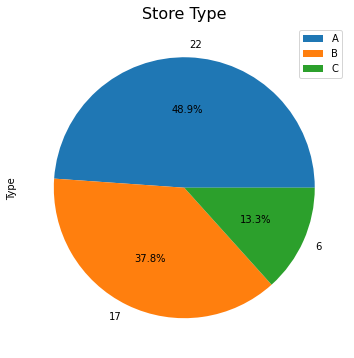

In [195]:
groupby_store = df_train_pd.groupby(['Store', 'Type']).size().index
store=list(groupby_store.get_level_values(0))
store_type=list(groupby_store.get_level_values(1))
type_df = pd.DataFrame(data={'Store': store, 'Type': store_type})

plot = type_df["Type"].value_counts().plot.pie(autopct="%1.1f%%", figsize=(6, 6), labels=type_df["Type"].value_counts())
plot.set_title("Store Type")
# plt.axis("off")
plt.legend(labels=type_df["Type"].value_counts().index, loc="upper right")
plt.title("Store Type", fontsize=16)

###Store size

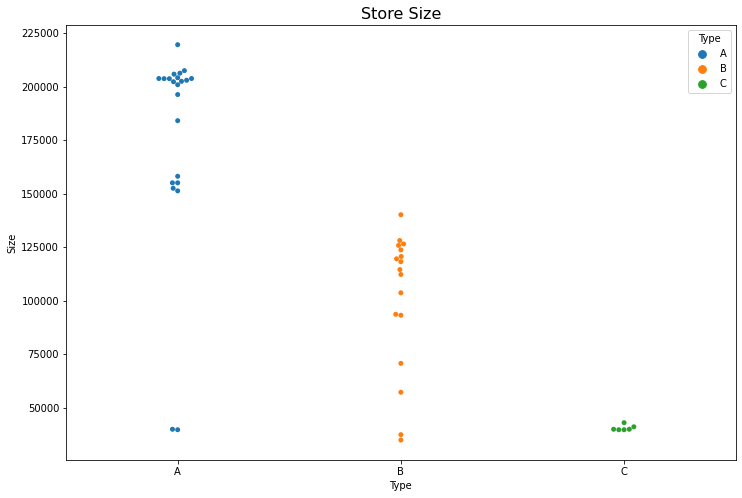

In [196]:
plt.figure(figsize=(12,8))
plt.title("Store Size", fontsize=16)
size_df = df_train_pd.groupby(['Store','Type'],as_index=False).median()
sns.swarmplot(x='Type',y="Size", data=size_df, hue = 'Type')

###Weekly Sales by year

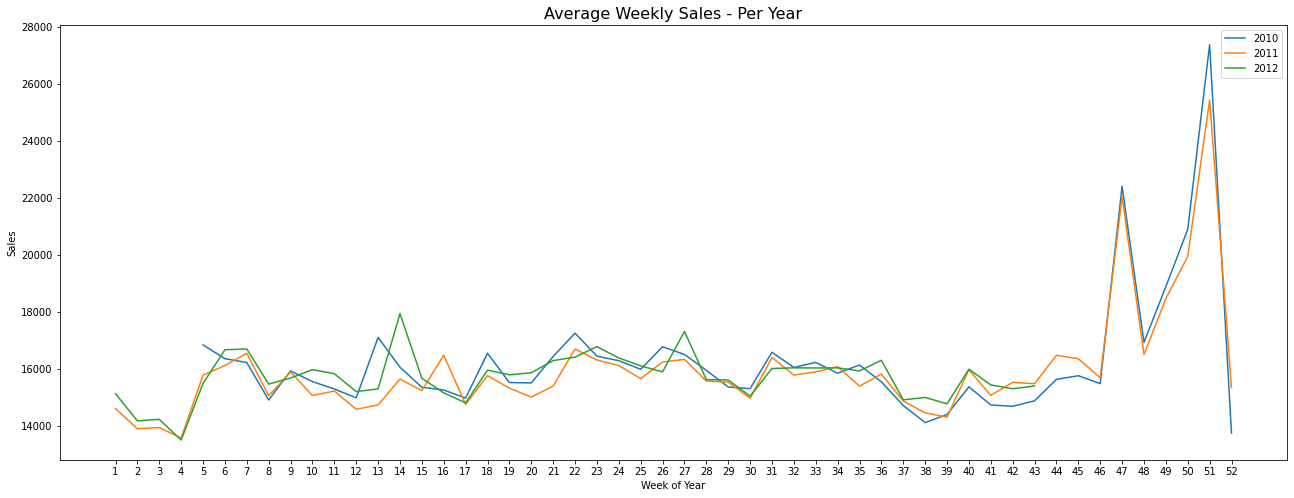

In [197]:
weekly_sales_2010 = df_train_pd[df_train_pd.Year==2010].groupby('Week')['Weekly_Sales'].mean()
weekly_sales_2011 = df_train_pd[df_train_pd.Year==2011].groupby('Week')['Weekly_Sales'].mean()
weekly_sales_2012 = df_train_pd[df_train_pd.Year==2012].groupby('Week')['Weekly_Sales'].mean()

plt.figure(figsize=(22,8))
plt.plot(weekly_sales_2010.index, weekly_sales_2010.values)
plt.plot(weekly_sales_2011.index, weekly_sales_2011.values)
plt.plot(weekly_sales_2012.index, weekly_sales_2012.values)

plt.xticks(np.arange(1, 53, step=1))
# plt.yticks( fontsize=16)
plt.xlabel('Week of Year')
plt.ylabel('Sales')

plt.title("Average Weekly Sales - Per Year", fontsize=16)
plt.legend(['2010', '2011', '2012']);

###Weekly Sales by Store

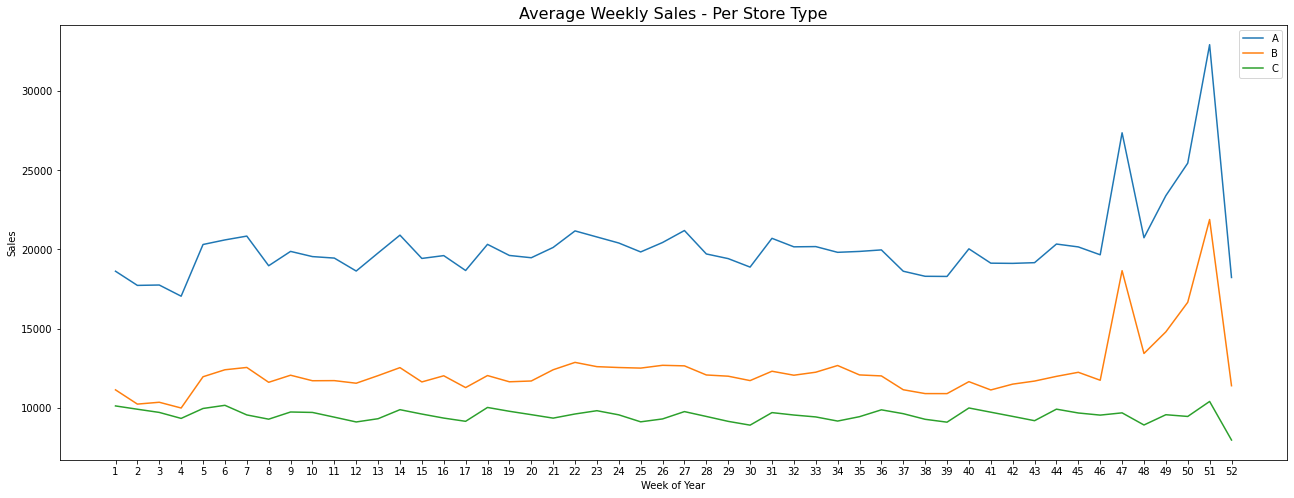

In [198]:
weekly_sales_A = df_train_pd[df_train_pd.Type=='A'].groupby('Week')['Weekly_Sales'].mean()
weekly_sales_B = df_train_pd[df_train_pd.Type=='B'].groupby('Week')['Weekly_Sales'].mean()
weekly_sales_C = df_train_pd[df_train_pd.Type=='C'].groupby('Week')['Weekly_Sales'].mean()

plt.figure(figsize=(22,8))
plt.plot(weekly_sales_A.index, weekly_sales_A.values)
plt.plot(weekly_sales_B.index, weekly_sales_B.values)
plt.plot(weekly_sales_C.index, weekly_sales_C.values)

plt.xticks(np.arange(1, 53, step=1))
# plt.yticks( fontsize=16)
plt.xlabel('Week of Year')
plt.ylabel('Sales')

plt.title("Average Weekly Sales - Per Store Type", fontsize=16)
plt.legend(['A', 'B', 'C']);

Text(0.5, 1.0, 'Overall Average Weekly Sales')

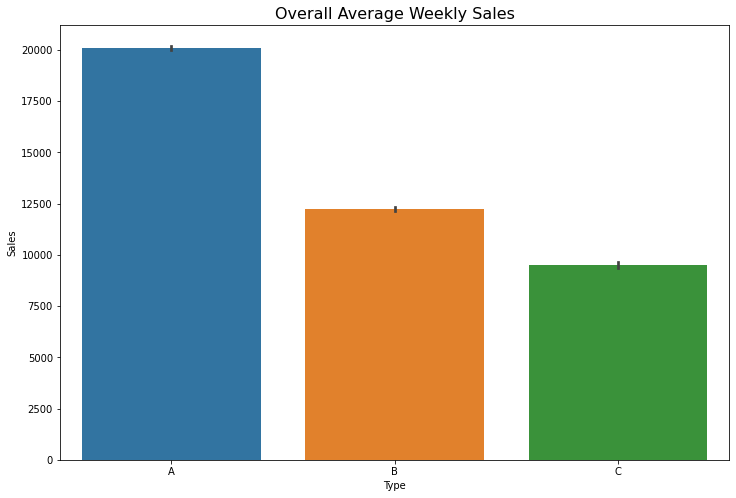

In [199]:
plt.figure(figsize=(12,8))
sns.barplot(data=df_train_pd, x='Type', y='Weekly_Sales')
plt.xlabel('Type')
plt.ylabel('Sales')
plt.title("Overall Average Weekly Sales", fontsize=16)

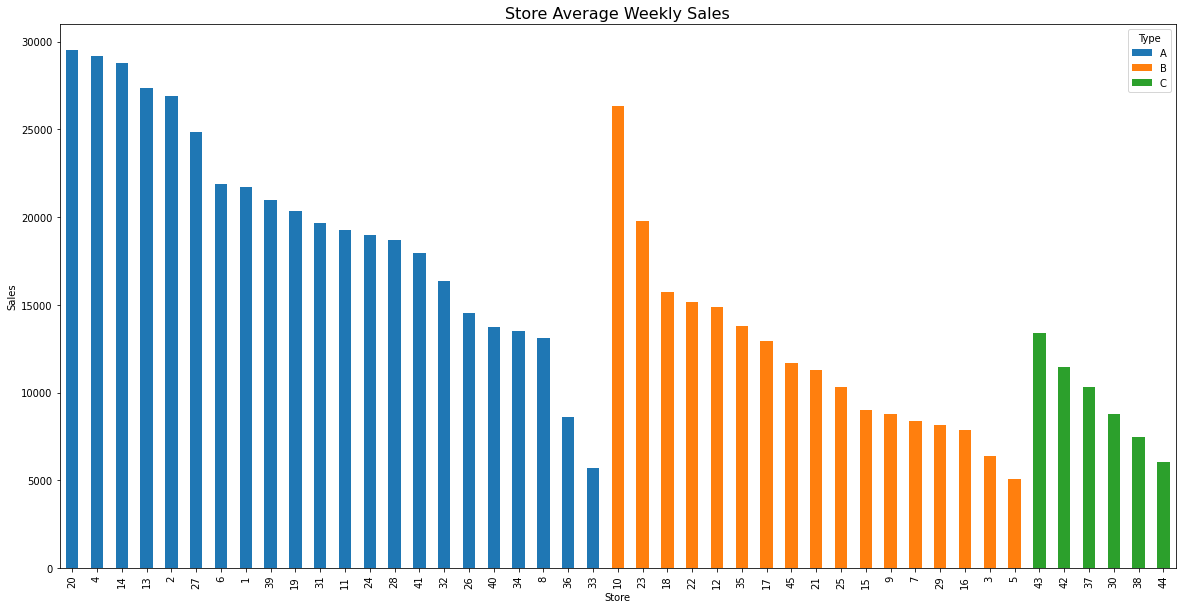

In [200]:
df_train_pd.sort_values(by = "Weekly_Sales", ascending = False, ignore_index=True)
dfp = df_train_pd.pivot_table(index='Store', columns='Type', values='Weekly_Sales', aggfunc='mean')
dfp.sort_values(by = ["A","B","C"], ascending=False,inplace=True)
dfp.plot(kind = 'bar',stacked=True,figsize=(20, 10))


plt.ylabel('Sales')
plt.title("Store Average Weekly Sales", fontsize=16)
plt.show()

In [201]:
dfp

Type,A,B,C
Store,,,
20,29508.301592,NaN,NaN
4,29161.210415,NaN,NaN
14,28784.851727,NaN,NaN
13,27355.136891,NaN,NaN
2,26898.070031,NaN,NaN
27,24826.984536,NaN,NaN
6,21913.243624,NaN,NaN
1,21710.543621,NaN,NaN
39,21000.763562,NaN,NaN


### Regional Features by Month

In [202]:
df_train_pd_month= df_train_pd.copy()
df_train_pd_month['YM']=(df_train_pd_month.Year.astype('str')) +" - " + (df_train_pd_month.Month.astype('str'))

In [203]:
df_train_pd_month.head()

,Store,Date,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Size,Year,Month,Week,IsSuperbowl,IsLabor,IsThanksgiving,IsChristmas,IntType,YM
0,1,2010-02-05,0,1,24924.50,42.31,2.572,NaN,NaN,NaN,...,151315,2010,2,5,0,0,0,0,NaN,2010 - 2
1,1,2010-02-12,1,1,46039.49,38.51,2.548,NaN,NaN,NaN,...,151315,2010,2,6,1,0,0,0,NaN,2010 - 2
2,1,2010-02-19,0,1,41595.55,39.93,2.514,NaN,NaN,NaN,...,151315,2010,2,7,0,0,0,0,NaN,2010 - 2
3,1,2010-02-26,0,1,19403.54,46.63,2.561,NaN,NaN,NaN,...,151315,2010,2,8,0,0,0,0,NaN,2010 - 2
4,1,2010-03-05,0,1,21827.90,46.50,2.625,NaN,NaN,NaN,...,151315,2010,3,9,0,0,0,0,NaN,2010 - 3


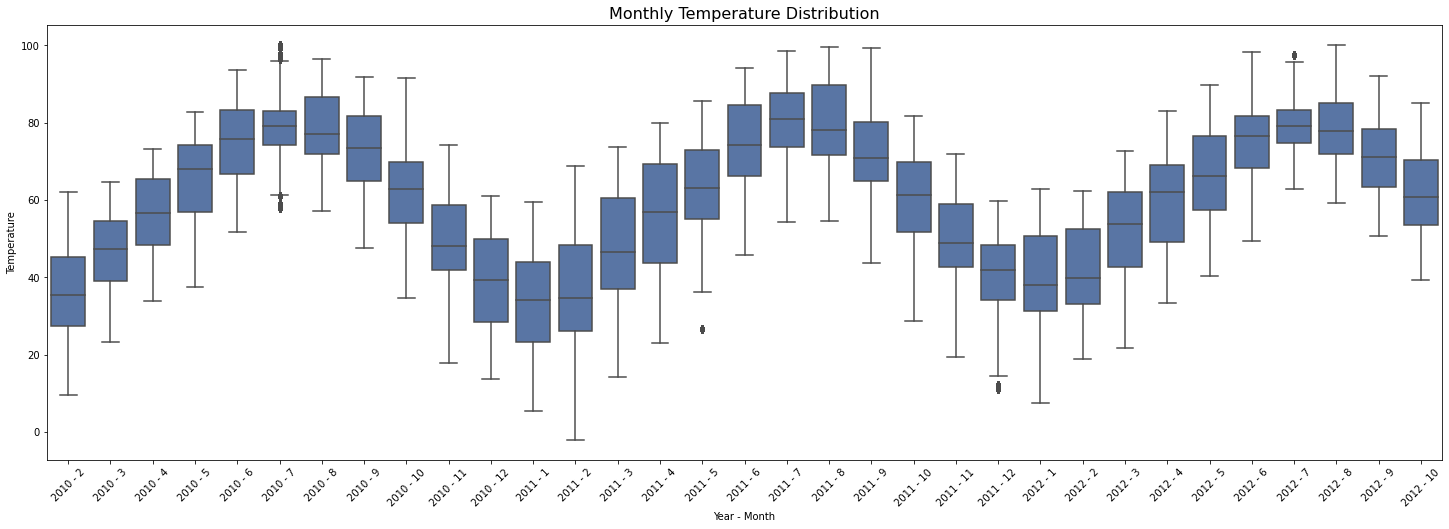

In [204]:
plt.figure(figsize=(25,8))
sns.boxplot(data = df_train_pd_month, x="YM", y="Temperature", color=sns.color_palette('deep')[0])
plt.xticks(rotation=45)

plt.xlabel('Year - Month')
plt.title("Monthly Temperature Distribution", fontsize=16)
plt.show()

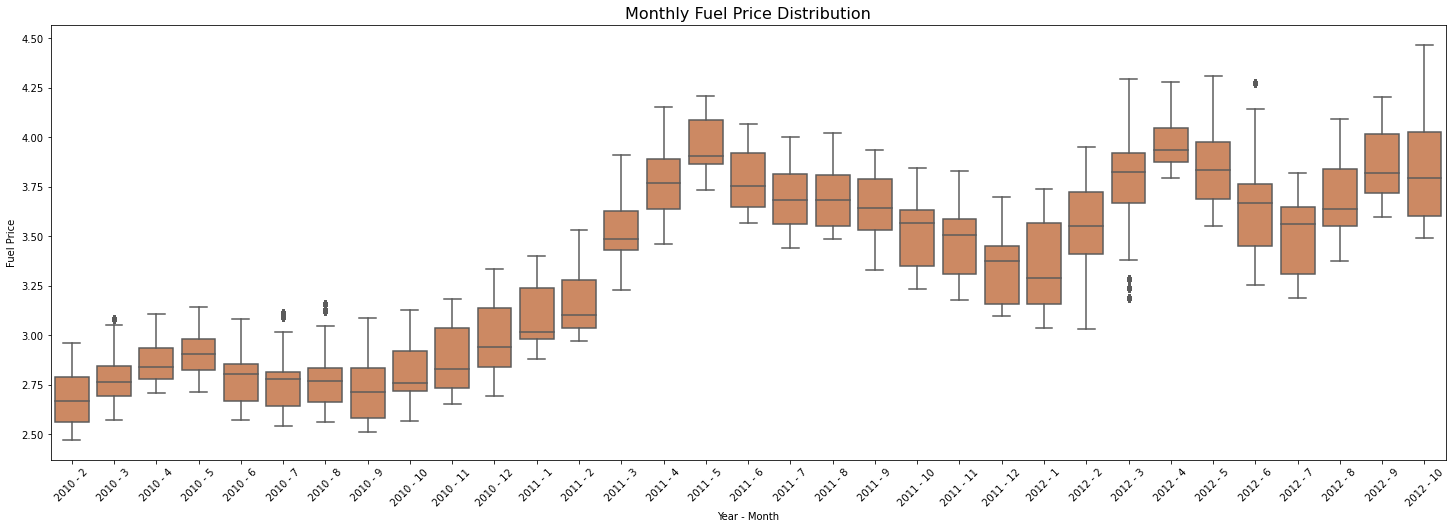

In [205]:
plt.figure(figsize=(25,8))
sns.boxplot(data = df_train_pd_month, x="YM", y="Fuel_Price", color=sns.color_palette('deep')[1])
plt.xticks(rotation=45)
plt.xlabel('Year - Month')
plt.ylabel('Fuel Price')
plt.title("Monthly Fuel Price Distribution", fontsize=16)
plt.show()

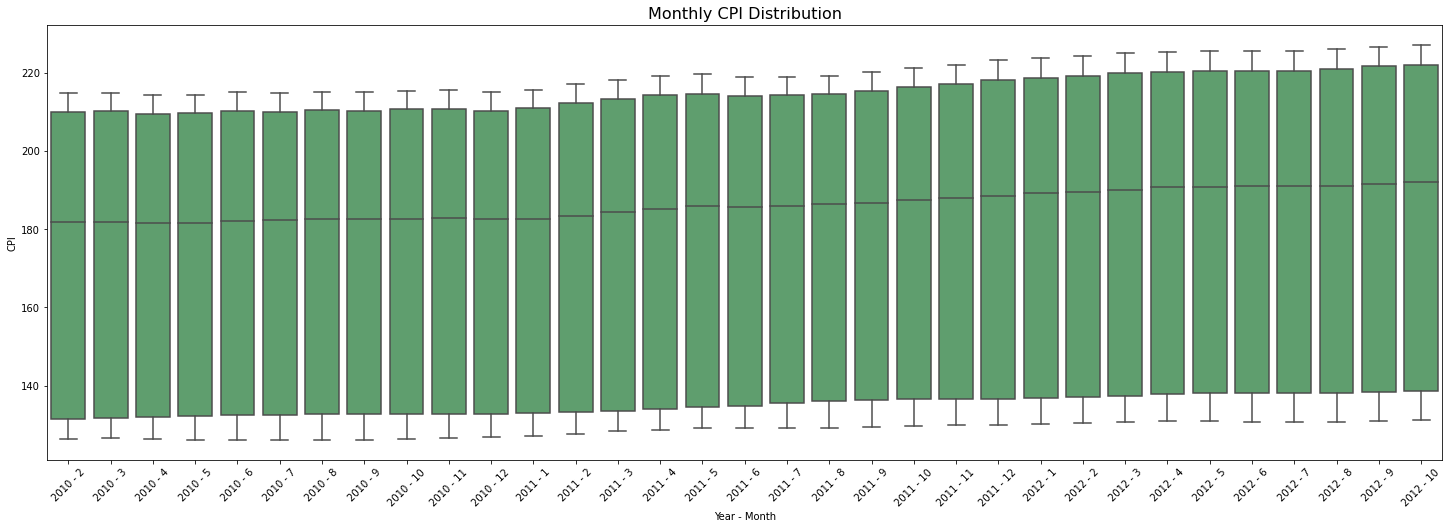

In [206]:
plt.figure(figsize=(25,8))
sns.boxplot(data = df_train_pd_month, x="YM", y="CPI", color=sns.color_palette('deep')[2])
plt.xticks(rotation=45)
plt.xlabel('Year - Month')
plt.title("Monthly CPI Distribution", fontsize=16)
plt.show()

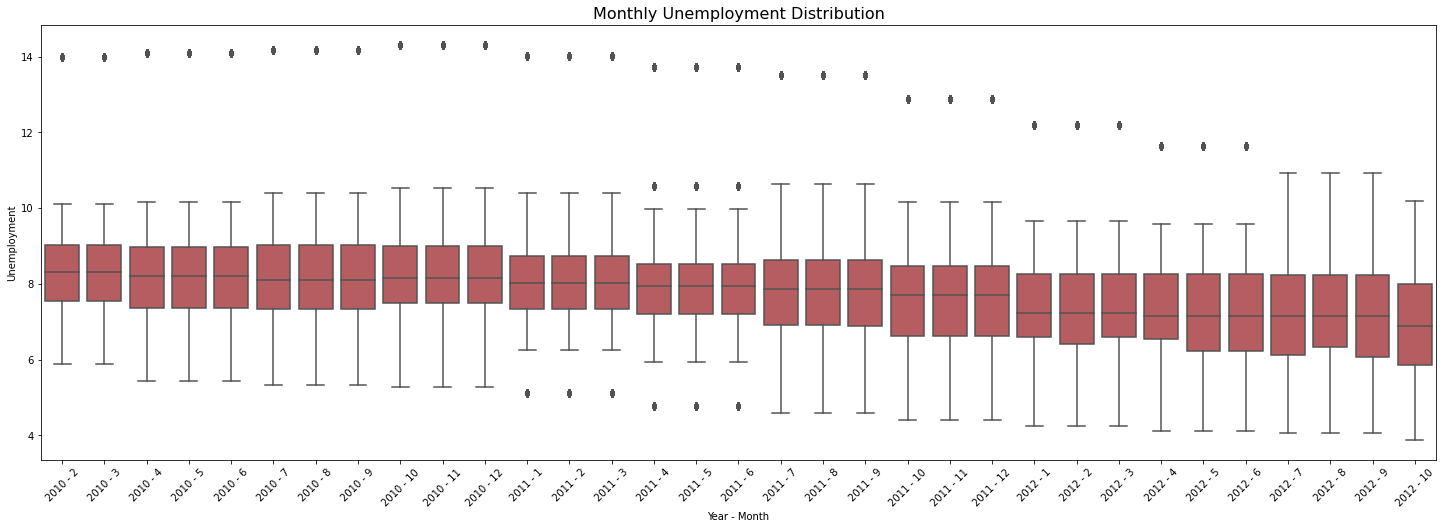

In [207]:
plt.figure(figsize=(25,8))
sns.boxplot(data = df_train_pd_month, x="YM", y="Unemployment", color=sns.color_palette('deep')[3])
plt.xticks(rotation=45)

plt.xlabel('Year - Month')
plt.title("Monthly Unemployment Distribution", fontsize=16)
plt.show()

###Weekly Sales by Department

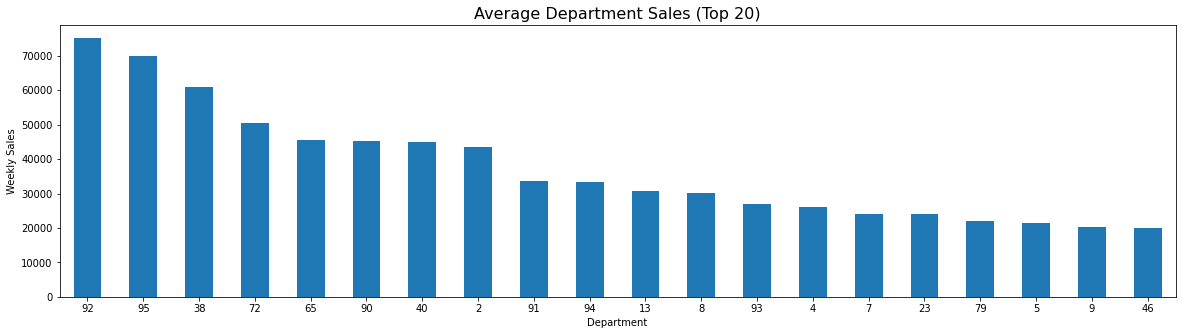

In [208]:
plt.figure(figsize=(20,5))
df_train_pd.groupby('Dept')['Weekly_Sales'].mean().sort_values(ascending=False)[:20].plot(subplots=True, kind='bar')
plt.xticks(rotation=0)
plt.xlabel('Department')
plt.ylabel('Weekly Sales')
plt.title("Average Department Sales (Top 20)", fontsize=16)
plt.show()


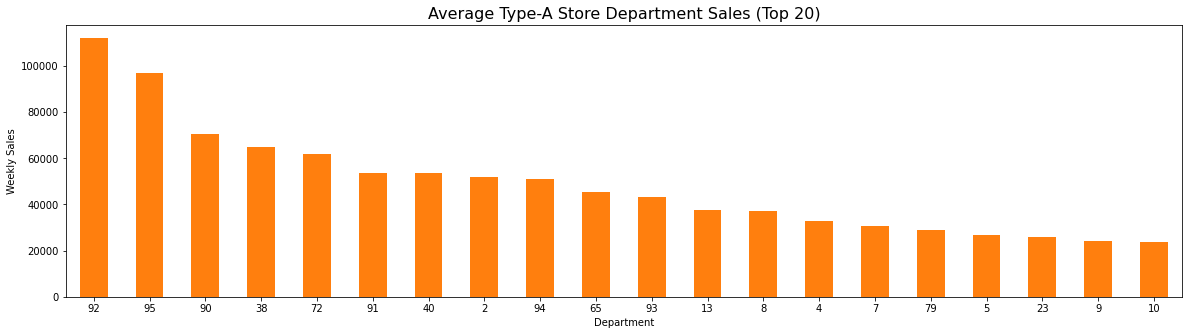

In [209]:
plt.figure(figsize=(20,5))
df_train_pd[df_train_pd.Type=='A'].groupby('Dept')['Weekly_Sales'].mean().sort_values(ascending=False)[:20].plot(kind='bar', color=plt.get_cmap("tab10")(1))
plt.xticks(rotation=0)
plt.xlabel('Department')
plt.ylabel('Weekly Sales')
plt.title("Average Type-A Store Department Sales (Top 20)", fontsize=16)
plt.show()

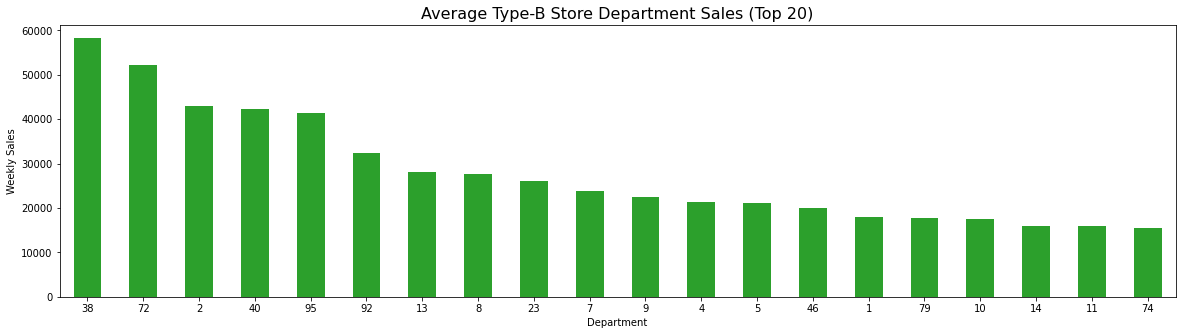

In [210]:
plt.figure(figsize=(20,5))
df_train_pd[df_train_pd.Type=='B'].groupby('Dept')['Weekly_Sales'].mean().sort_values(ascending=False)[:20].plot(kind='bar', color=plt.get_cmap("tab10")(2))
plt.xticks(rotation=0)
plt.xlabel('Department')
plt.ylabel('Weekly Sales')
plt.title("Average Type-B Store Department Sales (Top 20)", fontsize=16)
plt.show()


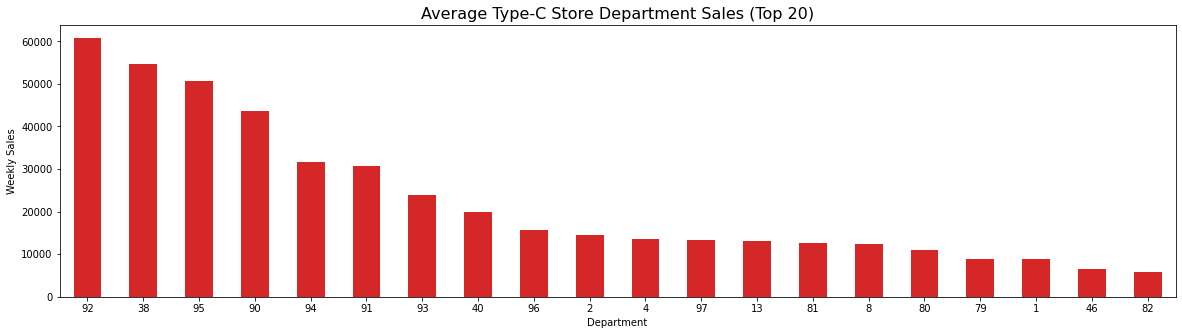

In [211]:
plt.figure(figsize=(20,5))
df_train_pd[df_train_pd.Type=='C'].groupby('Dept')['Weekly_Sales'].mean().sort_values(ascending=False)[:20].plot(kind='bar', color=plt.get_cmap("tab10")(3))
plt.xticks(rotation=0)
plt.xlabel('Department')
plt.ylabel('Weekly Sales')
plt.title("Average Type-C Store Department Sales (Top 20)", fontsize=16)
plt.show()


In [212]:
import plotly.express as px
departmentsales = df_train_pd.groupby('Dept')['Weekly_Sales'].mean().sort_values()
fig2 = px.bar(departmentsales,
x=departmentsales.values,
y=departmentsales.index,
title="Average Sales for Each Department",
color_discrete_sequence=["#114D77"], orientation='h',
labels={'x': 'Average Sales', 'y': 'Department'})
fig2.update_yaxes(tick0=1, dtick=10)
fig2.show()

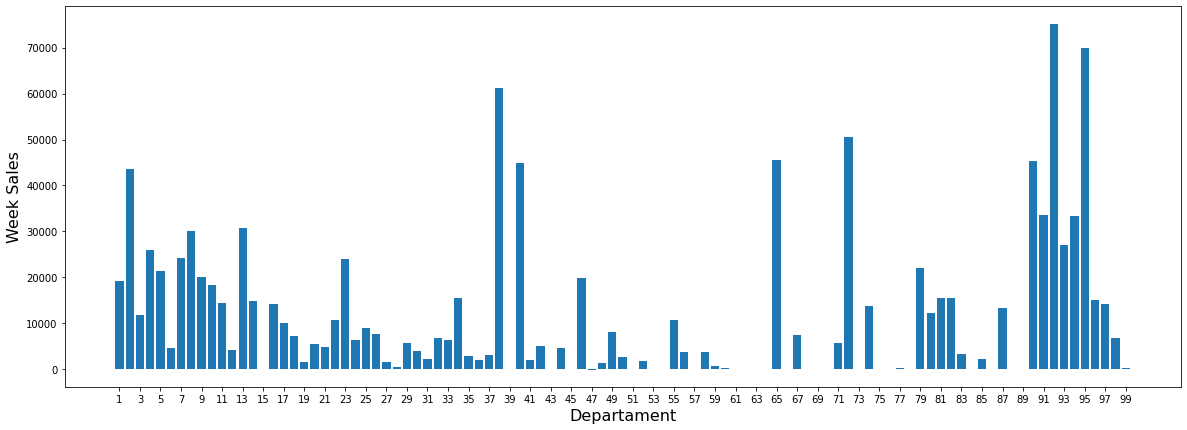

In [213]:
departament = df_train_pd.groupby(['Dept']).agg({'Weekly_Sales': ['mean', 'median']})
plt.figure(figsize=(20, 7))
plt.bar(departament.index, departament['Weekly_Sales']['mean'])
plt.xticks(np.arange(1, 100, step=2))
plt.ylabel('Week Sales', fontsize=16)
plt.xlabel('Departament', fontsize=16)
plt.show()

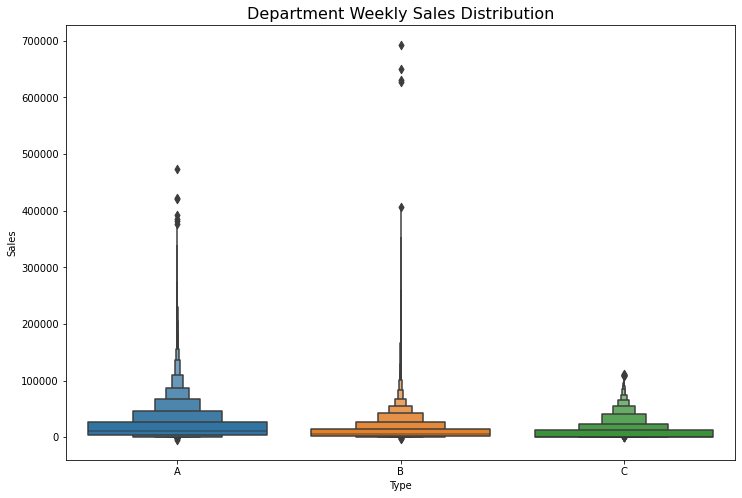

In [214]:
# plt.subplot(1,2,2)
plt.figure(figsize=(12,8))
sns.boxenplot(y=df_train_pd['Weekly_Sales'],x=df_train_pd['Type'])
plt.ylabel('Sales')
plt.title("Department Weekly Sales Distribution", fontsize=16)
plt.show()

###Weekly sales by Regional Features

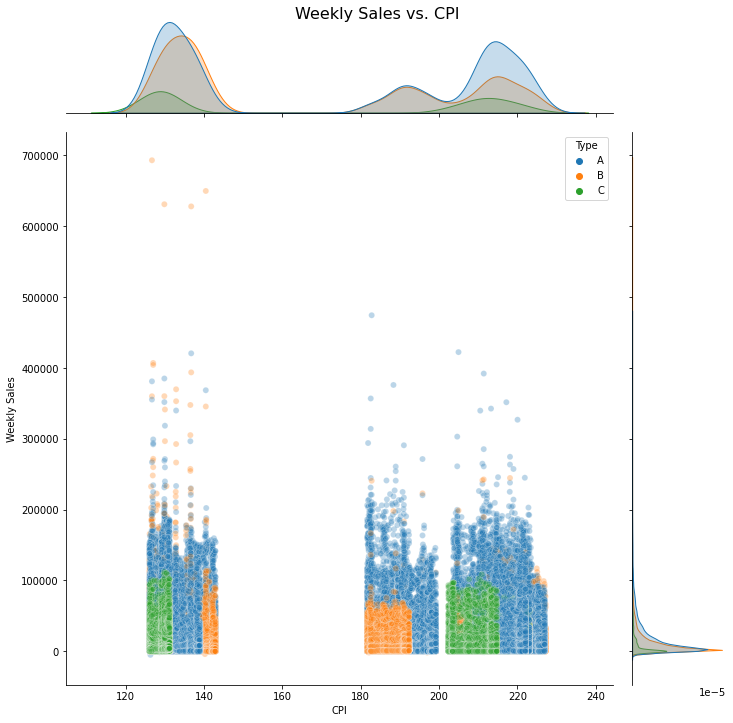

In [215]:

h = sns.jointplot(data=df_train_pd, x="CPI", y="Weekly_Sales", hue="Type", alpha = 0.3, height = 10)
h.set_axis_labels("CPI","Weekly Sales")
plt.suptitle("Weekly Sales vs. CPI", fontsize=16, y =1)
plt.show()

<Figure size 1800x1800 with 0 Axes>

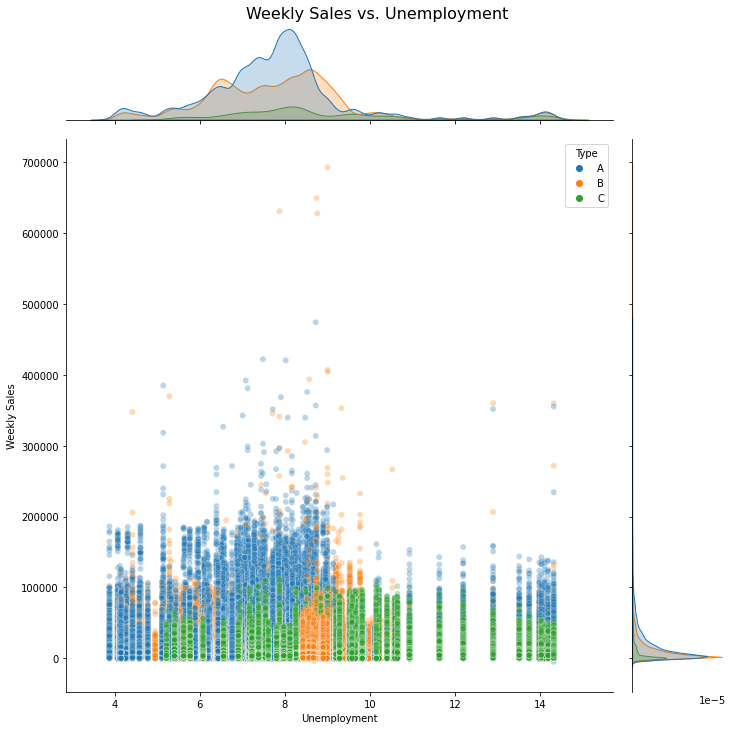

In [216]:
h = sns.jointplot(data=df_train_pd, x="Unemployment", y="Weekly_Sales", hue="Type", alpha = 0.3,height = 10)
h.set_axis_labels("Unemployment","Weekly Sales")
plt.suptitle("Weekly Sales vs. Unemployment", fontsize=16, y =1.01)
plt.show()

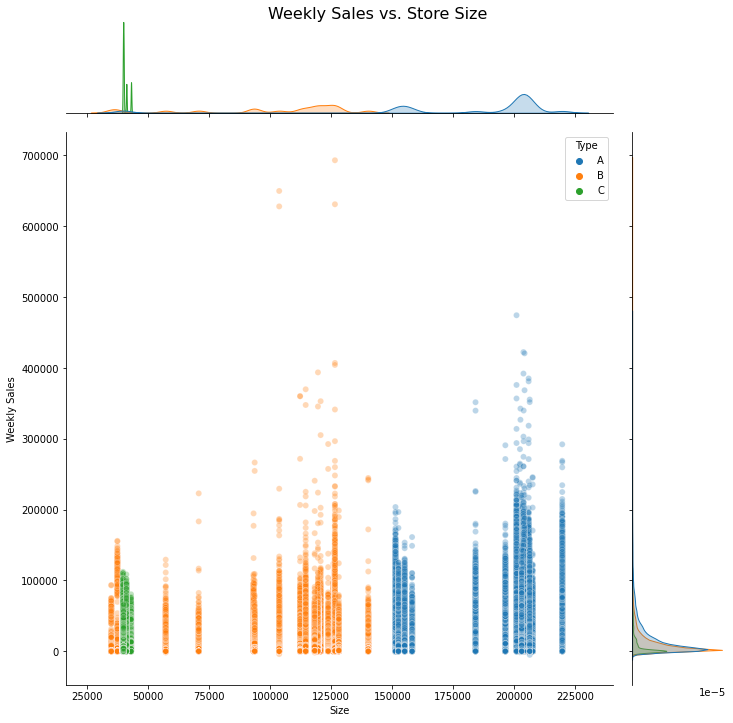

In [217]:
h = sns.jointplot(data=df_train_pd, x="Size", y="Weekly_Sales", hue="Type",alpha = 0.3,height = 10)
h.set_axis_labels("Size","Weekly Sales")
plt.suptitle("Weekly Sales vs. Store Size", fontsize=16, y =1)
plt.xticks(rotation=45)
plt.show()

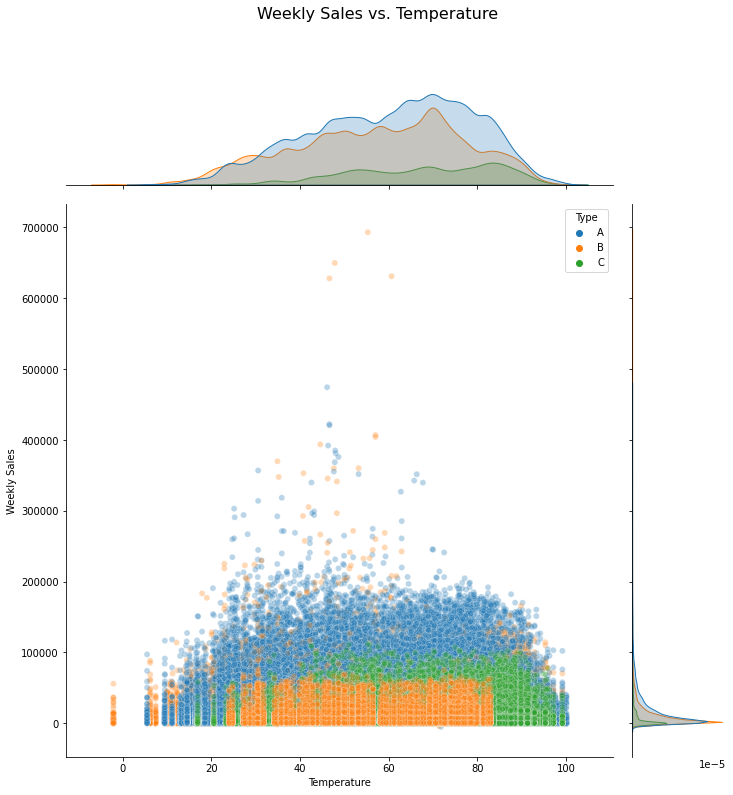

In [218]:
h = sns.jointplot(data=df_train_pd, x="Temperature", y="Weekly_Sales", hue="Type",alpha = 0.3,height = 10)
h.set_axis_labels("Temperature","Weekly Sales")
plt.suptitle("Weekly Sales vs. Temperature", fontsize=16, y =1.1)
plt.show()

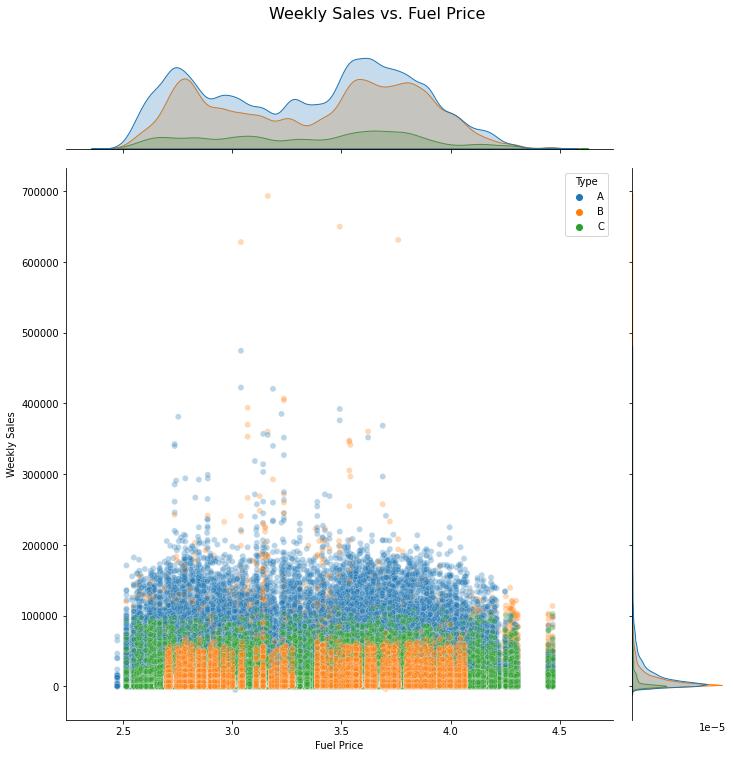

In [219]:
h = sns.jointplot(data=df_train_pd, x="Fuel_Price", y="Weekly_Sales", hue="Type",alpha = 0.3,height = 10)
h.set_axis_labels("Fuel Price","Weekly Sales")
plt.suptitle("Weekly Sales vs. Fuel Price", fontsize=16, y =1.05)
plt.show()

Holiday Sales impact on Weekly Sales

Text(0.5, 0.98, 'Holiday and non-Holiday Record Count')

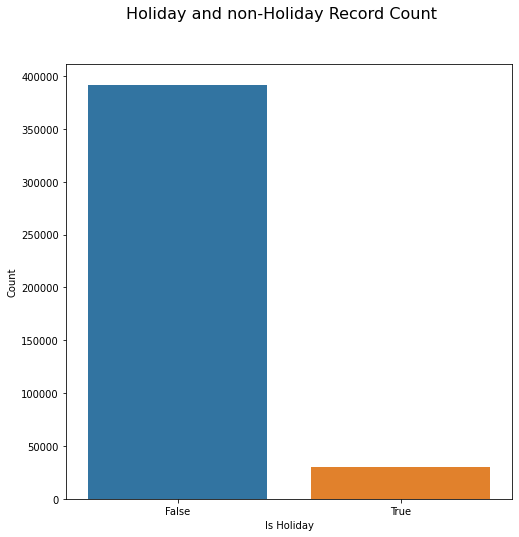

In [220]:
plt.figure(figsize=(8,8))
h = sns.countplot(data = df_train_pd, x="IsHoliday")
h.set_xticklabels(['False', 'True'])
h.set_xlabel("Is Holiday")
h.set_ylabel("Count")
plt.suptitle("Holiday and non-Holiday Record Count", fontsize=16)

Text(0.5, 0.98, 'Average Weekly Sales of Holiday and non-Holiday')

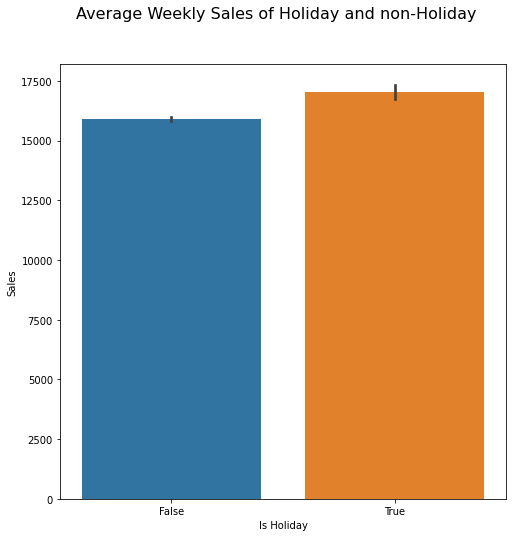

In [221]:
plt.figure(figsize=(8,8))
h=sns.barplot(data=df_train_pd, x='IsHoliday', y='Weekly_Sales')
h.set_xticklabels(['False', 'True'])
h.set_xlabel("Is Holiday")
h.set_ylabel("Sales")
plt.suptitle("Average Weekly Sales of Holiday and non-Holiday", fontsize=16)

###Correlation

In [222]:
df_train_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 24 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Store           421570 non-null  int32         
 1   Date            421570 non-null  datetime64[ns]
 2   IsHoliday       421570 non-null  int32         
 3   Dept            421570 non-null  int32         
 4   Weekly_Sales    421570 non-null  float64       
 5   Temperature     421570 non-null  float64       
 6   Fuel_Price      421570 non-null  float64       
 7   MarkDown1       150681 non-null  float64       
 8   MarkDown2       111248 non-null  float64       
 9   MarkDown3       137091 non-null  float64       
 10  MarkDown4       134967 non-null  float64       
 11  MarkDown5       151432 non-null  float64       
 12  CPI             421570 non-null  float64       
 13  Unemployment    421570 non-null  float64       
 14  Type            421570 non-null  obj

In [223]:
numeric_cols = list(df_train_pd.select_dtypes('number'))

In [227]:
numeric_cols.remove("IntType")

In [229]:
from scipy.stats import spearmanr
from scipy.stats import pearsonr
data_cols=list(numeric_cols)
data_cols_inner=list(numeric_cols)
print('Pearsons correlation coefficient:')
for i in (data_cols):
  data_cols_inner.remove(i)
  # print(data_cols_inner)
  for j in data_cols_inner:
    # interpret the significance
    alpha = 0.05
    coef, p = pearsonr(df_train_pd.dropna(subset=[i,j])[i], df_train_pd.dropna(subset=[i,j])[j])
    
    if p > alpha:
      print(i+" vs "+j+": %.3f" % coef)
      # print('Samples are uncorrelated (fail to reject H0) p=%.3f+\n' % p)
    # else:
      # print('Samples are correlated (reject H0) p=%.3f' % p)

Pearsons correlation coefficient:
Store vs IsHoliday: -0.001
Store vs Year: 0.003
Store vs Month: 0.001
Store vs Week: 0.001
Store vs IsSuperbowl: -0.001
Store vs IsLabor: 0.000
Store vs IsThanksgiving: -0.000
Store vs IsChristmas: -0.000
IsHoliday vs Dept: 0.001
IsHoliday vs MarkDown4: -0.001
IsHoliday vs CPI: -0.002
IsHoliday vs Size: 0.001
Dept vs MarkDown1: -0.002
Dept vs MarkDown2: 0.000
Dept vs MarkDown3: 0.002
Dept vs MarkDown4: 0.004
Dept vs MarkDown5: 0.000
Dept vs Size: -0.003
Dept vs Month: 0.001
Dept vs Week: 0.001
Dept vs IsSuperbowl: 0.001
Dept vs IsLabor: -0.000
Dept vs IsThanksgiving: 0.000
Dept vs IsChristmas: 0.000
Weekly_Sales vs Temperature: -0.002
Weekly_Sales vs Fuel_Price: -0.000
Weekly_Sales vs IsSuperbowl: 0.003
Weekly_Sales vs IsLabor: -0.001
MarkDown2 vs Month: -0.005
MarkDown2 vs Week: -0.001
MarkDown5 vs Unemployment: -0.004
CPI vs IsLabor: 0.002
CPI vs IsThanksgiving: -0.001
CPI vs IsChristmas: -0.001
Size vs Month: -0.001
Size vs Week: -0.001
Size vs IsSu